In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns;
import random
from tqdm import tqdm_notebook as tqdm

In [2]:
class Blackjack:
    def __init__(self):
        '''
        initialize valiue for state value , state visit count
        '''
        #We have added 3 '10' because face card have values 10
        self.possibleCard = list(range(1, 11)) + [10, 10, 10]
        self.action = [0,1] # 0 for HIT and 1 for STICK
        self.stateValue,self.stateVisitCount,self.playerSum,self.dealerCard = self.initilalizeVs()
        self.policy = self.initialPolicy()
        
    def initilalizeVs(self):
        '''
        State in a blackjack game consist of three things
        1) current sum in Player hand (12 to 21)
        2) dealer one showing card (ace to 10)
        3) Player Ace is usable or not  (True or false)
        Defining a 3D Matrix to store the state-values 
        '''
        stateValue = dict()
        stateVisitCount = dict()
        playerSum = [i for i in range(12,22)]
        dealerCard = [i for i  in range(1,11)]
        for i in playerSum:
            for j in dealerCard:
                for k in [True,False]:
                    #Adding a List of 2 because we want to store the state action value
                    stateValue[(i,j,k)] = np.zeros(2)
                    stateVisitCount[(i,j,k)] = np.zeros(2)
        return stateValue,stateVisitCount,playerSum,dealerCard
    
    
    def giveCard(self):
        '''
        Gives random card in the middle of the game
        '''
        return np.random.choice(self.possibleCard)
    
    def deal2Cards(self,forDealer=  False):
        '''
        return : cardsSum,usableAce,cards[0]
        This method is to deal two cards to the player or dealer
        if for Dealer then pass True in forDealer paramenter
        for dealer it return show card
        '''
        cardsSum, usableAce = 0,False
        cards = [self.giveCard(),self.giveCard()]
        if 1 in cards:
            cardsSum = np.sum(cards) + 10
            usableAce = True
        else:
            cardsSum = np.sum(cards)
            usableAce = False
        if(forDealer):
            return cardsSum,usableAce,cards[0]
        else:
            return cardsSum,usableAce,0
        
        
    def dealerTurn(self,cardsSum,usableAce):
        '''
        This method will play whole of dealer turn
        '''
        while True:
            '''
            Dealer Policy 
            if sum > 17 stick 
            if sum < 17 hit
            '''
            if(cardsSum >= 17):
                return cardsSum,usableAce
            else:
                newCard = self.giveCard()
                if newCard == 1:
                    if usableAce: # checking this condition because one can have only one usable Ace
                        cardsSum += 1
                    else: 
                        cardsSum += 11
                        usableAce = True
                else:
                    cardsSum += newCard
            
            '''
            if Sum is >21 and usable ace is True that means we are counting Ace as 11 
            so in this case we can count Ace as 1 and continue to hit
            '''
            if cardsSum > 21 and usableAce:
                cardsSum -= 10
                usableAce = False
            else:
                return cardsSum,usableAce

    
    def initialPolicy(self):
        '''
        Player Policy to be evaluated
        if sum >= 20 stick 
        if sum < 20 hit
        '''
        policy = dict()
        for i in range(2,22):
            for j in self.dealerCard:
                for k in [True,False]:
                    if(i< 12):
                        policy[(i,j,k)] = 0 # Always HIT as sum is less than 
                    if(i >= 20):
                        policy[(i,j,k)] = 1 # STICK
                    else:
                        policy[(i,j,k)] = 0  # HIT
        return policy
        
    def nextState(self,state,action):
        '''
        Method to make the next transition based on Action and current state 
        '''
        currentSum,dealerCard,usableAce = state
        if (action == 0): #i.e. HIT
            newCard = self.giveCard()
            if newCard == 1:
                if usableAce: # checking this condition because one can have only one usable Ace
                    currentSum += newCard
                else: 
                    currentSum += 11
                    usableAce = True
            else:
                currentSum += newCard
        else: #i.e. STICK
            return (currentSum,dealerCard,usableAce), True
        
        '''
        Check if card sum has exceded 21 and change state accordingly
        '''
        isEnd = False
        if currentSum > 21 and usableAce:
            currentSum -= 10 
            usableAce = False
        else:
            isEnd = True
        
        return (currentSum,dealerCard,usableAce), isEnd
    
    def decideReward(self,playerSum,dealerSum):
        '''
        Decide Winner of the game based on the current SUM of Player and Dealer
        Rewards of +1, −1, and 0 are given for winning, losing, and drawing
        '''
        reward = 0
        if playerSum > 21:
            if dealerSum > 21:
                #draw
                reward = 0
            else:
                # dealer wins
                reward =  -1
        else:
            if dealerSum > 21:
                #Player wins
                reward = 1
            else:
                #If both Sum is less than 21 that whose sum is closer is 21 that one wins
                if playerSum > dealerSum:
                    #Player wins
                    reward = 1
                elif playerSum < dealerSum:
                    #Dealer wins
                    reward = -1
                else:
                    #match draws
                    reward =  0
        return reward
                    
      

In [3]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = np.max(V[player, dealer, ace])
    
    X, Y = np.meshgrid(dealer_show,player_sum)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 1])
    ax2.plot_wireframe(X, Y, state_values[:, :, 0])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')

In [4]:
noOfGames= 500000
bj = Blackjack()
win  = 0
windraw = 0
for i in tqdm(range(1,noOfGames + 1)):
    playerCardsSum,playerUsableAce,_ = bj.deal2Cards(forDealer=False)
    dealerCardsSum,dealerUsableAce,dealerShowcard = bj.deal2Cards(forDealer=True)
    if playerCardsSum == 21 or dealerCardsSum == 21:
        continue
#     if(playerCardsSum <= 11):
#         continue
    #player initial state
    state = (playerCardsSum,dealerShowcard,playerUsableAce)
    stateReachedInEpisode = []
    while True:
        '''
        Firstly Player take Action
        '''
        action = bj.policy[state]
        if state[0] >= 12  and state[0] <= 21:
            stateReachedInEpisode.append((state,action))
        state,isEnd = bj.nextState(state,action)
        if isEnd:
            break
    '''
    Now dealer will play his turn
    '''
    dealerCardsSum,dealerUsableAce = bj.dealerTurn(dealerCardsSum,dealerUsableAce)
    reward = bj.decideReward(state[0],dealerCardsSum)
    #Will have to Update the state values now.
    for j in range(len(stateReachedInEpisode) - 1,-1,-1):
        if stateReachedInEpisode[j] not in stateReachedInEpisode[0: j-1]:
            S,A = stateReachedInEpisode[j]
            bj.stateVisitCount[S][A] +=1
            bj.stateValue[S][A] += (1/bj.stateVisitCount[S][A]) * (reward - bj.stateValue[S][A])
            bj.policy[S] = np.argmax(bj.stateValue[S])
            

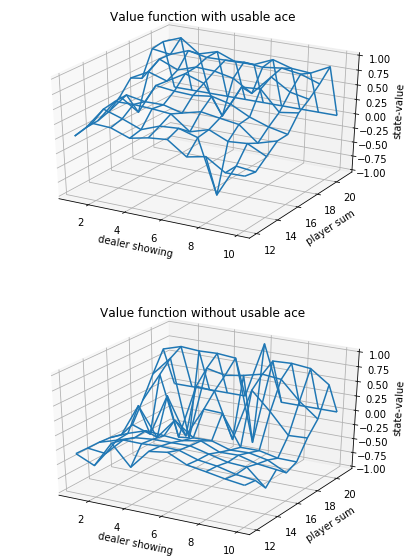

In [5]:
fig, axes = plt.subplots(nrows=2, figsize=(7, 10),subplot_kw={'projection': '3d'})
axes[0].set_title('Value function with usable ace')
axes[1].set_title('Value function without usable ace')
plot_blackjack(bj.stateValue, axes[0], axes[1])
plt.show()

### Plot graph 

In [6]:
player_sum = np.arange(12, 21 + 1)
dealer_show = np.arange(1, 10 + 1)
usable_ace = np.array([True, False])
state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_show):
        for k, ace in enumerate(usable_ace):
            state_values[i, j, k] = bj.policy[player, dealer, ace] 

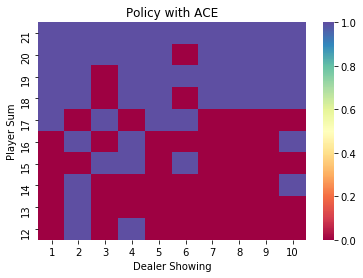

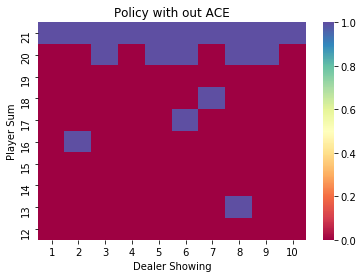

In [7]:
ax1 = sns.heatmap(np.flip(state_values[:, :, 1],0),xticklabels = dealer_show, yticklabels = np.flipud(player_sum),cmap="Spectral")
ax1.set_title('Policy with ACE')
ax1.set_ylabel('Player Sum')
ax1.set_xlabel('Dealer Showing')
plt.show()
ax2 = sns.heatmap(np.flip(state_values[:, :, 0],0),xticklabels = dealer_show, yticklabels = np.flipud(player_sum),cmap="Spectral")
ax2.set_title('Policy with out ACE')
ax2.set_ylabel('Player Sum')
ax2.set_xlabel('Dealer Showing')
plt.show()